In [1]:
import warnings
import time
warnings.simplefilter('ignore')

import logging
logging.basicConfig(format='%(levelname)-8s [%(asctime)s] s(%(module)s : %(funcName)s) %(message)s',level=logging.INFO)
logging.info("application started")
logging.info("")
logging.info("")
# будем отображать графики прямо в jupyter'e
%pylab inline
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import pandas as pd
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,roc_auc_score
from sklearn.preprocessing import StandardScaler



sns.set(rc=rcParams)
sns.set_style("darkgrid", {
    "axes.facecolor": "#282828",
    "axes.edgecolor":"#282828",
    "grid.color":"#298F4A",
    "xtick.color":"1",
    "ytick.color":"1",
    "text.color":"1",
    "axes.labelcolor":"1",
    "figure.facecolor":"#282828"
})
sns.set_palette(sns.color_palette("BrBG", 7))

INFO     [2017-07-20 14:06:53,097] s(<ipython-input-1-bdddafa7cc9d> : <module>) application started
INFO     [2017-07-20 14:06:53,102] s(<ipython-input-1-bdddafa7cc9d> : <module>) 
INFO     [2017-07-20 14:06:53,105] s(<ipython-input-1-bdddafa7cc9d> : <module>) 


Populating the interactive namespace from numpy and matplotlib


/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:53.047563. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
def process(x):
    x=str(x).replace(',','.')
    
    if str(x)[-1]=='%':
        x=x[:-1]
    try:
        a=float(x)
        while(a>1):
            a=a/100
        return a
    except Exception as e:
            return 0.0
def clear(x):
    if x[0] in '0123456789':
        x=x[6:]
    x=x.strip()
    if "Цифровые продажи" in x:
        return "Цифровые продажи" 
    elif "Уведомления" in x:
        return "Уведомления"
    else :
        return x
def readFile(filename):
    df=pd.DataFrame()
    for (root,dirs,files) in os.walk(filename):
        for file in files:
            day=pd.read_csv(root+"/"+file,delimiter="\t",)
            day['date']=str(file[:-4])
            df=df.append(day)
    df=df.reset_index()
    del df['index']
    df.project=df.project.apply(clear)
    
    df['date']=pd.to_datetime(df['date'],yearfirst=True,dayfirst=True)
    
    df=df.rename(columns={"процент":"percent"})
   
    df.percent=df.percent.apply(process)
    return df

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:54.670886. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# чтение и обработка файлов

In [3]:
may_june=readFile('./data/IFT results/may-june/')      
april_may=readFile('./data/IFT results/april-may/')

april_may=april_may[april_may.project!='SberPay (ex E-Инвойсинг)']

# may_june.head()
# april_may.head()
# april_may.sort('project').groupby('project').count()
# may_june.sort('project').groupby('project').count()

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:54.741943. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [4]:
# pd.get_dummies(april_may,columns=['project']).head()
# april_may_cat=pd.get_dummies(april_may,columns=['project'])
# may_june_cat=pd.get_dummies(may_june,columns=['project'])

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:55.263292. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# 

In [33]:
full = pd.DataFrame.append(april_may.rename(columns={'процент':'percent'}),may_june)
aaa=full.set_index('project')
gr=aaa.groupby(aaa.index)
X=[]
Y=[]
Xval=[]
Yval=[]
index=0

def append(X,Y,group):
    first=True
    for x in group.sort('date')['percent']:
        X.append(x)    
        if first:
            Y.append(0)
            first=False
        else:
            Y.append(X[-1])


for name,group in gr:
    first=True
    if index%9 == 0: #TODO refactor
        len(group)#,group.index[0]
        append(Xval,Yval,group)
    else :
        append(X,Y,group)
    index+=1
# print(index)

53

52

53

In [6]:
X=np.array(X)
X=X.reshape((X.shape[0],1))
Y=np.array(Y)
Y=Y.reshape((Y.shape[0],1))

Xval=np.array(Xval)
Xval=Xval.reshape((Xval.shape[0],1))
Yval=np.array(Yval)
Yval=Yval.reshape((Yval.shape[0],1))


X.shape
Y.shape
Xval.shape
Yval.shape

xs=StandardScaler()
ys=StandardScaler()

X=xs.fit_transform(X)
Y=ys.fit_transform(Y)
Xval=xs.transform(Xval)
Yval=ys.transform(Yval)

trainX,testX,trainY,testY=train_test_split(X,Y,test_size=0.3,random_state=12315)
trainX[0]

(1109, 1)

(1109, 1)

(158, 1)

(158, 1)

array([-1.1643538])

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:55.444705. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
trainPairX=np.array([(trainX[start],trainX[start+1]) for start in range(len(trainX)-2)])
trainPairX=trainPairX.reshape((trainPairX.shape[0],2))

trainPairY=trainY[2:]

trainPairX.shape,trainPairX[:10]
trainPairY.shape,trainPairY[:10]

testPairX=np.array([(testX[start],testX[start+1]) for start in range(len(testX)-2)])
testPairX=testPairX.reshape((testPairX.shape[0],2))
testPairY=testY[2:]

valPairX=np.array([(Xval[start],Xval[start+1]) for start in range(len(Xval)-2)])
valPairX=valPairX.reshape((valPairX.shape[0],2))
valPairY=Yval[2:]

((774, 2), array([[-1.1643538 , -0.39887857],
        [-0.39887857,  1.19538187],
        [ 1.19538187, -0.73269484],
        [-0.73269484, -0.01326323],
        [-0.01326323, -0.07081776],
        [-0.07081776, -1.18939002],
        [-1.18939002,  1.54070904],
        [ 1.54070904, -0.01211214],
        [-0.01211214,  0.87883196],
        [ 0.87883196,  1.54070904]]))

((774, 1), array([[ 1.19477344],
        [-0.72768133],
        [-0.01034746],
        [-0.06773417],
        [-1.18304487],
        [ 1.5390937 ],
        [-0.00919973],
        [ 0.87914654],
        [ 1.5390937 ],
        [-1.33024178]]))

/home/azaz/anaconda3/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-07-20 14:06:55.540073. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
from sklearn.model_selection import GridSearchCV
parameters ={
    'learning_rate':np.linspace(0.05,0.15,5),
    'max_depth':range(10,20,2),
    'subsample':np.linspace(0.5,1,5),
    "n_estimators":range(15,45,5)
}

# dtrain = xgb.DMatrix(trainPairX,trainPairY)
# dtest = xgb.DMatrix(testPairX,testPairY)

grid=GridSearchCV(xgb.XGBRegressor(),parameters,verbose=1,n_jobs=4,cv=4)
grid.fit(trainX,trainY)
grid.best_params_

Fitting 4 folds for each of 750 candidates, totalling 3000 fits


[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 1848 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done 3000 out of 3000 | elapsed:   26.5s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': range(10, 20, 2), 'subsample': array([ 0.5  ,  0.625,  0.75 ,  0.875,  1.   ]), 'learning_rate': array([ 0.05 ,  0.075,  0.1  ,  0.125,  0.15 ]), 'n_estimators': range(15, 45, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

{'learning_rate': 0.125, 'max_depth': 14, 'n_estimators': 40, 'subsample': 0.5}

In [39]:
reg=xgb.XGBRegressor(**{'learning_rate': 0.14999999999999999,
 'max_depth': 10,
 'n_estimators': 35,
 'subsample': 0.5}
)

reg=xgb.XGBRegressor(n_estimators=30,**{"learning_rate":0.1,"max_depth":15,"subsample":1})


Xval=np.array(Xval)
Xval=Xval.reshape((158,1))

# bst = xgb.train({"eta":0.1,"max_depth":15,"subsample":1},dtrain,num_boost_round=30)

#!!!!!!!
%time bst=reg.fit(trainX,trainY)

qwe=bst.get_booster()
qwe.save_model("./modelXGB_DayByDay.bin")
qwe.dump_model('dump.raw.txt')
# mul=500

# %time reg.fit(np.array(list(trainX)*mul),np.array(list(trainY)*mul))

# xgb.plot_importance(bst)
mean_squared_error(bst.predict(trainX),trainY)
mean_squared_error(bst.predict(testX),testY)
mean_squared_error(bst.predict(Xval),Yval)
list(zip(bst.predict(testX),testY))[:10]
# list(zip(bst.predict(Xval),Yval))[:10]

CPU times: user 16.2 ms, sys: 791 µs, total: 17 ms
Wall time: 16.8 ms


0.0044307014734256307

0.0021160711947834873

0.000453283806567721

[(0.12103626, array([ 0.10442596])),
 (0.43862128, array([ 0.43497341])),
 (-0.17089617, array([-0.20546227])),
 (-0.67516768, array([-0.72768133])),
 (1.4318016, array([ 1.46908191])),
 (-0.78469658, array([-0.84245475])),
 (0.34196815, array([ 0.3339728])),
 (-1.0399699, array([-1.11504162])),
 (-0.45059025, array([-0.49813449])),
 (-1.1139194, array([-1.18677501]))]

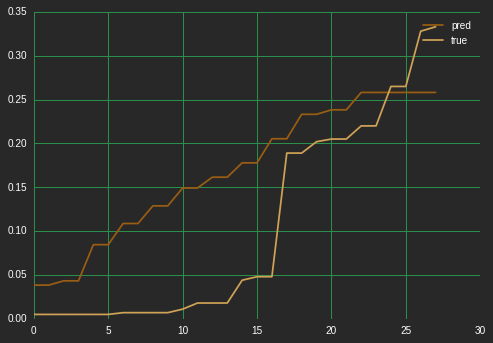

mse: 0.800223781891%


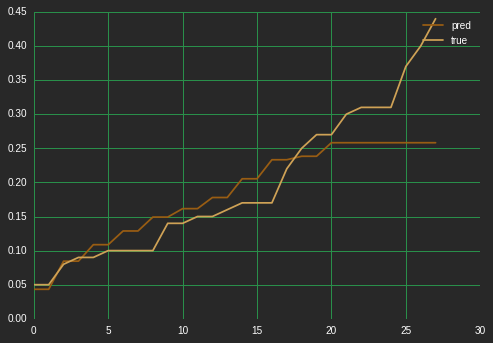

mse: 0.320834156028%


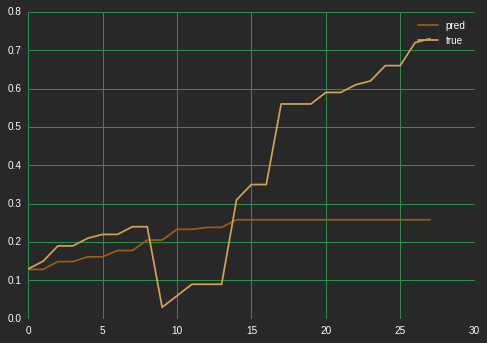

mse: 5.95772263966%


In [42]:
length=53
offset=0
def plotVal(arrX,arrY,offset,length):
    pred=np.array([arrX[offset]][0])   
    for i in range(0,length-1):
        pred=np.append(
            pred,
            bst.predict(
                pred[i-1]
            )
        )
    pred=pred[1:-1]
    plt.plot(pred)
    plt.plot(arrY[offset+1:offset+length-1])
    plt.legend(["pred","true"])
    plt.show()
    print("mse: "+str(mean_squared_error(pred,arrY[offset+1:offset+length-1])*100)+"%")
    print("="*120)

plotVal(Xval,Yval,0,30)
plotVal(Xval,Yval,53,30)
plotVal(Xval,Yval,53+52,30)
